# Figure 1: Regional Map of Europe

The following code generates a map of Europe with the boundaries of different regions highlighted. 

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value 

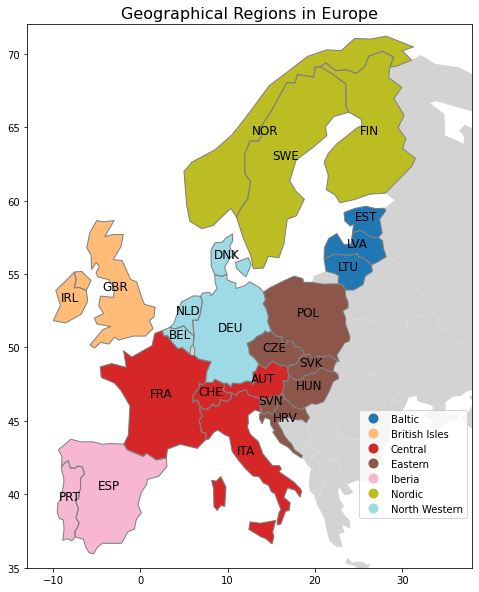

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon

# Load the world map and focus on Europe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

# Correct ISO codes for France and Norway
europe.loc[europe.name == "France", "iso_a3"] = 'FRA'
europe.loc[europe.name == "Norway", "iso_a3"] = 'NOR'

# Function to filter out overseas territories and keep only mainland Europe
def filter_multipolygon(geometry):
    if isinstance(geometry, MultiPolygon):
        # Keep only the Polygon(s) with centroid in mainland Europe
        mainland_polygons = [poly for poly in geometry if 65 > poly.centroid.y > -30 and poly.centroid.x > -30]
        return mainland_polygons[0] if mainland_polygons else None
    else:
        return geometry

# Apply the filter to France and Norway
europe.loc[europe['iso_a3'] == 'FRA', 'geometry'] = europe[europe['iso_a3'] == 'FRA']['geometry'].apply(filter_multipolygon)
europe.loc[europe['iso_a3'] == 'NOR', 'geometry'] = europe[europe['iso_a3'] == 'NOR']['geometry'].apply(filter_multipolygon)

# Define the regions and corresponding countries
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']
abr = ['NRD', 'BRI', 'NWE', 'CEN', 'IBA', 'BAL', 'EAS']
values = [
    ['NOR', 'SWE', 'FIN'],
    ['GBR', 'IRL'],
    ['DNK', 'DEU', 'NLD', 'BEL'],
    ['FRA', 'ITA', 'CHE', 'AUT'],
    ['ESP', 'PRT'],
    ['EST', 'LVA', 'LTU'],
    ['POL', 'HRV', 'HUN', 'CZE', 'SVN', 'SVK']
]

# Assign region abbreviation to each country in Europe
europe['Region'] = None
for i, region in enumerate(keys):
    europe.loc[europe['iso_a3'].isin(values[i]), 'Region'] = abr[i]

# Filter only the countries that belong to a defined region
regions = europe[europe['Region'].notnull()]

# Map region abbreviations to full region names
regions['Region names'] = regions['Region'].map(dict(zip(abr, keys)))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot Europe and regions
europe.plot(color='lightgrey', ax=ax)
regions.boundary.plot(ax=ax, linewidth=1, color='grey')
regions.plot(column='Region names', ax=ax, legend=True, 
            legend_kwds={'bbox_to_anchor': (1, 0.3)}, cmap=plt.cm.tab20)

# Get the legend and set the x/y axis limits
leg1 = ax.get_legend()
ax.set_xlim([-13, 38])  # Longitude range
ax.set_ylim([35, 72])   # Latitude range

# Add country abbreviations at the centroid of each country
for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['iso_a3']):
    ax.text(x, y, label, fontsize=12, ha='center', color='black')

# Set plot title
ax.set_title('Geographical Regions in Europe', fontsize=16)

# Save the figure as a high-resolution PNG
plt.savefig('regions.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
